# Gath - Geva Clustering

In [2]:

import numpy as np

First thing first, let's use the generator tools from previous works

In [3]:
import numpy as np
import matplotlib.pyplot as plt


def get_random_covariance(d):
    """
    Function to generate a random, valid covariance matrix of size d x d
    """
    sigma = np.random.rand(d, d) - 0.5
    sigma = np.dot(sigma, sigma.T)  # make the matrix symmetric
    return sigma


def get_random_gaussian_dist(d, distance=5):
    """
     generate a random Gaussian distribution with mean mu and covariance matrix sigma
    The distance parameter specifies the distance of the mean from the origin
    """
    sigma = get_random_covariance(d)  # generate a random covariance matrix
    mu = np.array(np.random.rand(d)) * distance  # generate a random mean
    return mu, sigma


def generate_normal_datapoint(guaussian_dist):
    """
     generate a single datapoint from a Gaussian distribution with mean and covariance matrix guaussian_dist
    """
    mean = guaussian_dist[0]
    cov = guaussian_dist[1]
    dp = np.random.multivariate_normal(mean, cov, check_valid='warn', tol=1e-8)
    return dp


def generate_gaussian_cluster(guaussian_dist, k,d = 2, dataset=None):
    """
    Function to generate a cluster of k datapoints from the Gaussian distribution guaussian_dist
    The dataset parameter can be used to append the generated cluster to an existing dataset
    gauss_dist is a tuple of the form (mean, covariance matrix)
    """
    cluster = np.empty((0, d))  # initialize an empty array to store the datapoints
    for i in range(k):
        p = generate_normal_datapoint(guaussian_dist)  # generate a single datapoint
        cluster = np.append(cluster, [p], axis=0)  # add the datapoint to the cluster
    if dataset:
        dataset = np.append(dataset, cluster)  # append the cluster to an existing dataset, if provided
    return cluster


def plot_loss(loss):
    plt.figure()
    plt.plot(range(len(loss)),loss)
    plt.title("loss vs. iteration no.")
    plt.xlabel("iteration")
    plt.ylabel("|loss|")
    plt.show()

def get_rand_centroids(K,d):
    centroids = np.random.rand(K, d)
    return centroids

In [48]:

def generate_clusters(k, d = 2,N =600, distance = 2):
    """
    generate k clusters of d-dimensional data

    :param k:           number of clusters
    :param d:           dimension of the data
    :param distance:    expected distance of the mean from the origin
    :return:            clusters - a list of clusters, where each cluster is a numpy array of datapoints
                        data - a numpy array of all the datapoints
                        phi - a numpy array of the priors of each cluster
                        sigma - a numpy array of the covariance matrices of each cluster
    """
    phi = np.random.rand(k)
    phi = phi/np.sum(phi)
    print(phi)

    # random distributions
    distributions = [get_random_gaussian_dist(d,distance) for i in range(k)]
    print(distributions[0])
    # generate clusters
    clusters = [generate_gaussian_cluster(distribution,int(phi[i]*N),d) for i, distribution in enumerate(distributions)]

    sigma = [distribution[1] for distribution in distributions]
    data = np.concatenate(clusters,axis=0)

    return clusters, data, phi, sigma



def plot_clusters(clusters, d = 2,title = None):

    """
    Function to plot the clusters
    input: clusters - a list of clusters, where each cluster is a numpy array of datapoints
           d - the dimension of the data
    output: a plot of the clusters, where each cluster is a different color, and the datapoints are transparent to show overlapping clusters

    """
    plt.figure()
    if d == 2:
        for c in clusters:
            plt.scatter(c[:,0], c[:, 1], alpha=0.5)
    else:
        for c in clusters:
            ax = plt.axes(projection='3d')
            ax.scatter3D(c[:,0], c[:, 1], c[:, 2], alpha=0.5)
    if title:
        plt.title(title)





In [55]:
def get_gaussian_line_shape_distribution(p1,p2):
    v = p2 - p1
    v_norm = np.linalg.norm(v)
    u = v/v_norm

    sigma = v_norm * np.outer(u,u)

    epsilon = 0.005 * np.identity(sigma.shape[0])
    sigma +=epsilon

    mu = p1 + (p2 - p1)/2

    return mu, sigma



# Classical fuzzy clustering: FCM

## the algorithm implementation
Fuzzy C-means (FCM) is a clustering algorithm that is used to partition data points $\{x_i\}_1^n$ into a predefined number of clusters $c$. The algorithm is a 'soft' clustering method, which allows each data point to belong to multiple clusters to a certain degree.

The FCM algorithm can be summarized as follows:

1. Initialize the cluster centers.
2. Calculate the membership degrees of each data point to each cluster.
$$ p(w_j|x_i) \leftarrow
    \frac
        {({\frac{1}{d_{ij} ^2 })^{1/b-1}}}
        {\sum_{i=1}^N({\frac{1}{d_{ij} ^2 })^{1/b-1}}}
        $$


3. Update the cluster centers based on the membership degrees.
$$\mu_{cx} \leftarrow \frac{
        \sum_{i=1}^N \hat p(w_i|x_j)^b \cdot x_j}
    {
        \sum_{i=1}^N \hat p(w_i|x_j)^b }$$

Repeat steps 2-3 until the cluster centers converge.


where $d_{ij} = d(x_i,c_j)$ is the distance between the data point $x$ and the cluster center $c_i$, $b$ is a fuzzifier parameter, and $C$ is the number of clusters.

The FCM algorithm is a versatile clustering algorithm that can be used to cluster data of different types. It is also relatively robust to noise and outliers.



In [49]:
import numpy as np

def fcm(data, K, initial_centroids, max_iters = 50, fuzziness = 2, tol = 0.001):
    # Randomly initialize cluster centers
    centroids = initial_centroids
    i=0
    converged = False
    iteration_loss = []
    while (not converged) and i < max_iters:
        # Calculate the membership matrix
        distances = np.linalg.norm(data[:, None] - centroids, axis=2)
        membership = 1 / (distances ** (2 / (fuzziness - 1)))
        membership = membership / np.sum(membership, axis=1)[:, None]

        # Update cluster centers
        m = membership ** fuzziness
        centroids = np.dot(m.T, data) / np.sum(m, axis=0)[:, None]

        clusters = [data[np.argmax(membership,axis=1)==i] for i in range(K)]

        if i<3 or not i%10 :
            plot_clusters(clusters, title=f'iteration {i}')
            # plt.figure()
            # c = np.argmax(membership,axis=1)
            # plt.scatter(data[:,0], data[:, 1],  c=c,alpha=0.5)
            # plt.title(f'iteration {i}')

        loss = np.sum((distances**2) * m)
        iteration_loss.append(loss)

        if i >20:
            converged = (abs(loss-iteration_loss[i-1]) < tol)
        i+=1
    plot_clusters(clusters, title=f'iteration {i}')
    return centroids, membership, iteration_loss

## generate the data

In [45]:

K = 2
d = 2
N = 1000
distance = 4
max_iters = 50
fuzziness = 2

clusters, data, phi, sigma = generate_clusters(K,d,N=N,distance=distance)

[0.54984306 0.45015694]
(array([0.38727699, 1.88040536]), array([[ 0.31498038, -0.23139404],
       [-0.23139404,  0.21038755]]))


## plot the data

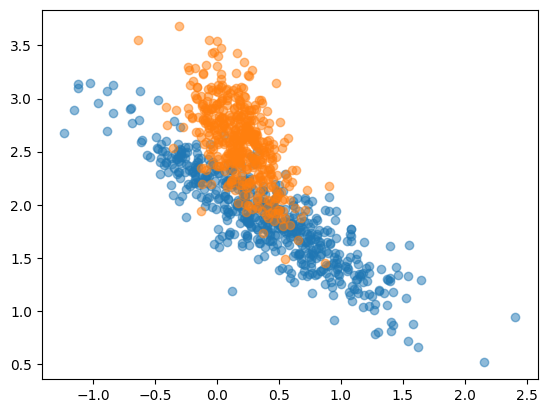

In [50]:
plot_clusters(clusters)


## run the algorithm

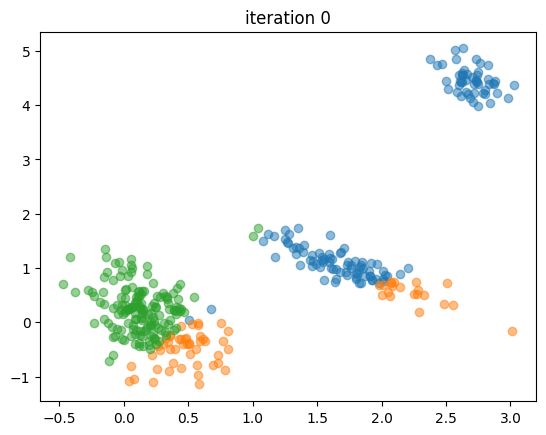

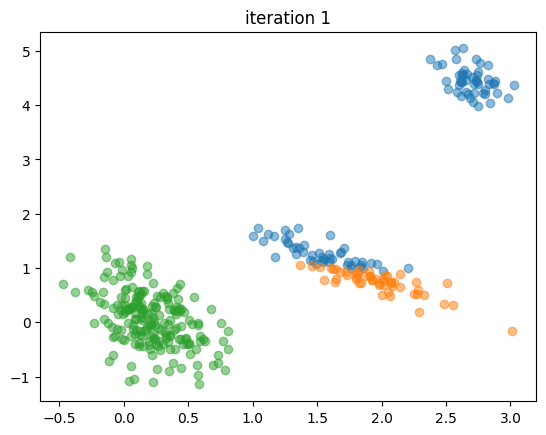

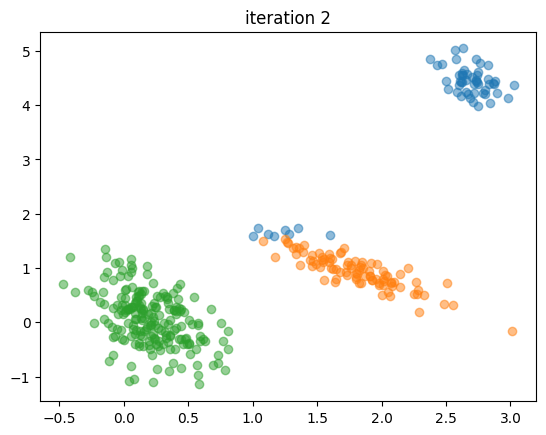

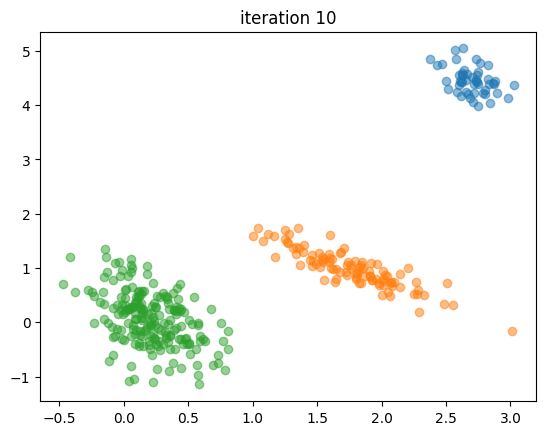

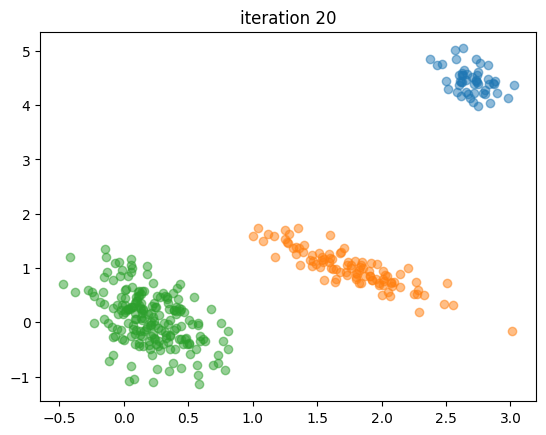

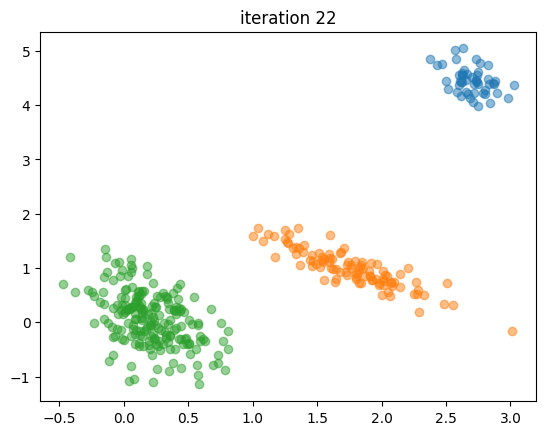

In [58]:
centroids = np.random.rand(K, data.shape[1])

centroids, membership, loss = fcm(data,K,centroids)

The WUOFC algorithm:

The WUOFC algorithm is a variant of the FCM algorithm that is used to cluster data points $\{x_i\}_1^n$ when the initialization centers $\{c_j\}_1^n$ are not known, but also when the number of clusters $K$ is not known.
the algorithm, prorposed in the Gath-Geva algorithm paprt, is a six-step algorithm:

1. Initialize the cluster centers. Initialize $K \leftarrow 1$, choose a single initial center $c_1$ at the center of mass of the data, $$c_1 = \frac{1}{N}\sum_{i=1}^N x_i$$
2. while $K < K_{max}$ do:
    - Calculate the new partition:
         - Call FCM with $K$ clusters and the current cluster centers $c_1, \ldots, c_K$. The output of the FCM algorithm is the membership matrix $p(w_j|x_i)$ and the cluster centers $\mu_{cx}$.
        - use the centroids $\mu_{cx}$ as the new cluster centers $c_1, \ldots, c_K$. as the initial cluster centers for the K-Means with exponential kernel algorithm.
    - calculate the cluster validity criteria $V$ for the partition.
    - add a new centroid, $c_{K+1}$ equally distant from all the other centroids, to the set of cluster centers. set $K \leftarrow K+1$.
3. return the partition with the highest validity criteria $V$.

In [81]:
def exponential_kernel(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y)**2)

def kmeans_with_exponential_kernel(data, k, max_iterations=100, gamma=1.0):
    """
    K-Means with exponential kernel
    :param data:
    :param k:
    :param max_iterations:
    :param gamma:
    :return:
    """
    n_samples, n_features = data.shape

    # Initialize cluster centers randomly
    cluster_centers = data[np.random.choice(n_samples, k, replace=False)]
    losses = []

    for _ in range(max_iterations):
        # Assign data points to the nearest cluster center
        labels = [np.argmin([exponential_kernel(x, center, gamma) for center in cluster_centers]) for x in data]
        new_cluster_centers = np.zeros((k, n_features))
        counts = np.zeros(k)

        # Update cluster centers based on the mean of the data points assigned to each cluster
        for i in range(n_samples):
            new_cluster_centers[labels[i]] += data[i]
            counts[labels[i]] += 1

        for j in range(k):
            if counts[j] > 0:
                new_cluster_centers[j] /= counts[j]

        clusters = [data[np.array(labels) == i] for i in range(k)]
        print(labels)
        plot_clusters(clusters, title=f'iteration {_}')
        # Check for convergence
        if np.allclose(cluster_centers, new_cluster_centers):
            break

        cluster_centers = new_cluster_centers
        loss = np.sum([exponential_kernel(x, cluster_centers[labels[i]], gamma) for i, x in enumerate(data)])
        losses.append(loss)

    return cluster_centers, labels, losses




In [72]:
def WUOFC(data, K_max, max_iters = 50, fuzziness = 2, tol = 0.001):
    pass

## generate the data

In [73]:

K = 3
max_iters = 50
fuzziness = 2


clusters = []
# Example usage
clusters.append( generate_gaussian_cluster(get_random_gaussian_dist(2),50))
clusters.append( generate_gaussian_cluster(get_random_gaussian_dist(2),100))
clusters.append( generate_gaussian_cluster(get_random_gaussian_dist(2),200))

# unify data
data = np.concatenate(clusters)

## plot the data

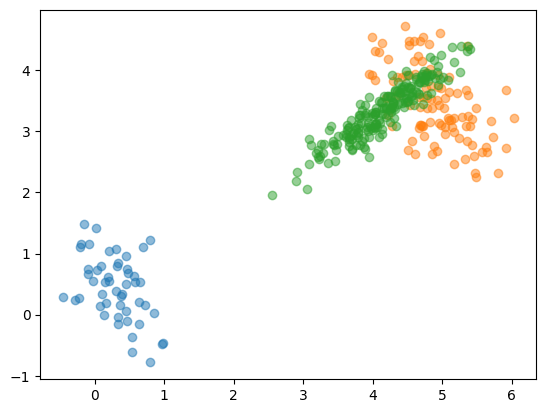

In [74]:
plot_clusters(clusters)

[0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[2, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0,

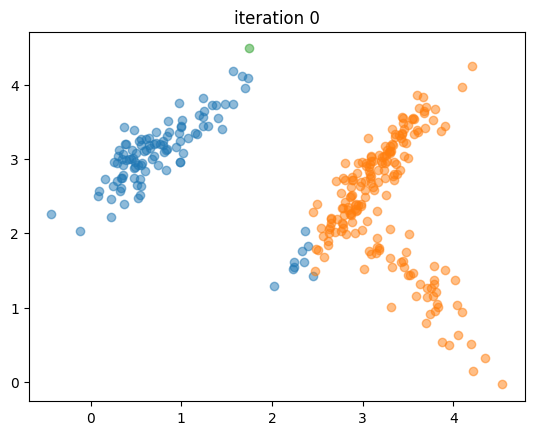

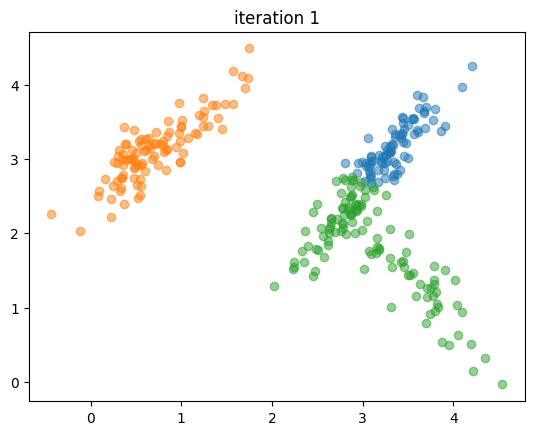

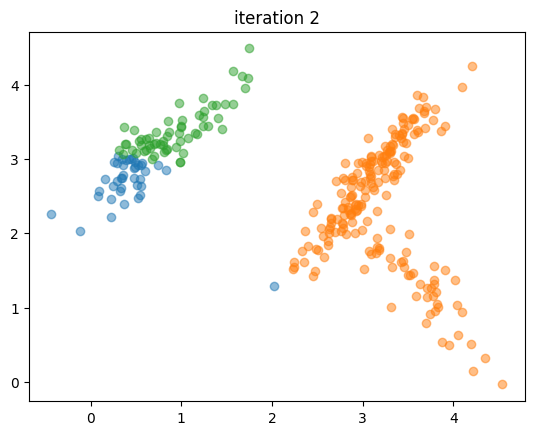

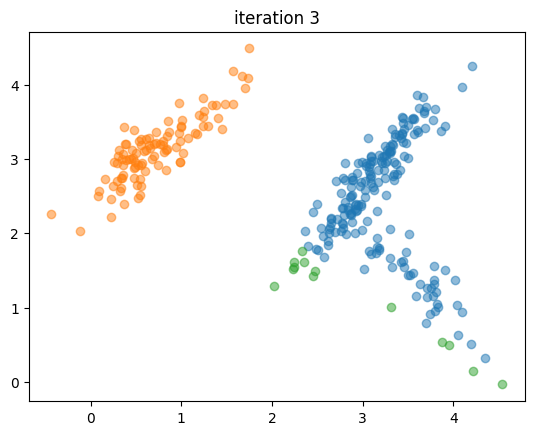

In [82]:
# initialize random centroids
centroids = np.random.rand(K, data.shape[1])

cluster_centers, labels, losses = kmeans_with_exponential_kernel(data, K, max_iterations=4, gamma=1.0)


In [76]:
K = 3
d = 2
max_iters = 50
fuzziness = 2

clusters = []
# Example usage
for _ in range(K):
    clusters.append(generate_gaussian_cluster(get_random_gaussian_dist(d),50*np.random.randint(1,4)))

# unify data
data = np.concatenate(clusters)

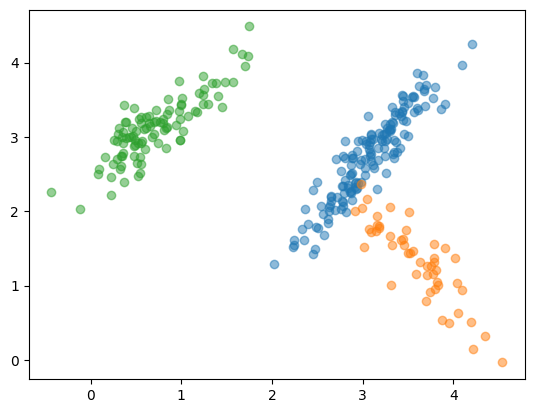

In [77]:
plot_clusters(clusters)

-0.0010158401026245656
-0.00035538293153081213


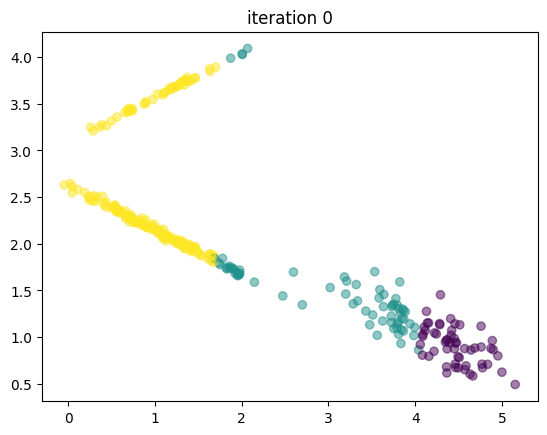

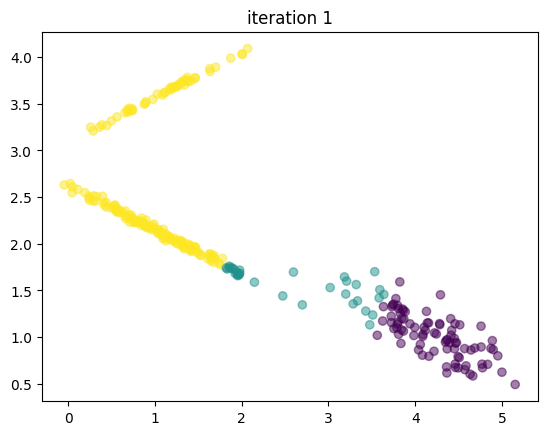

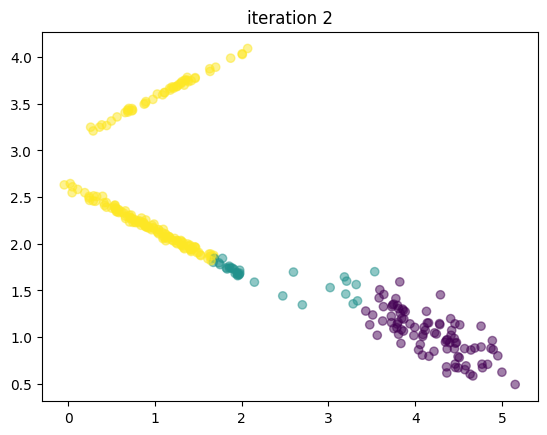

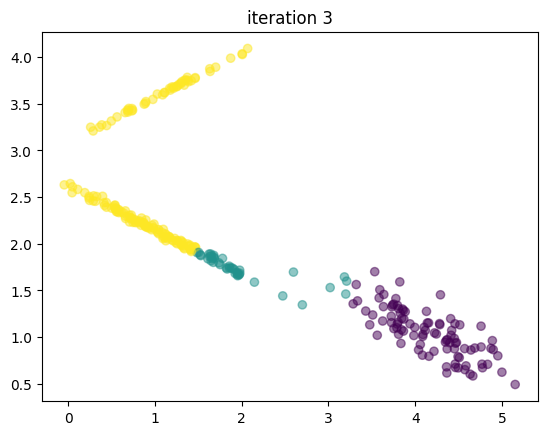

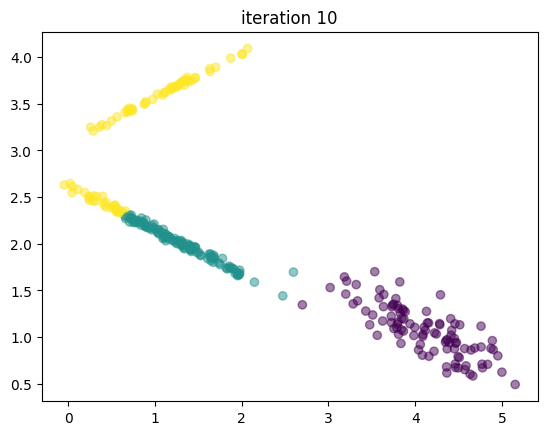

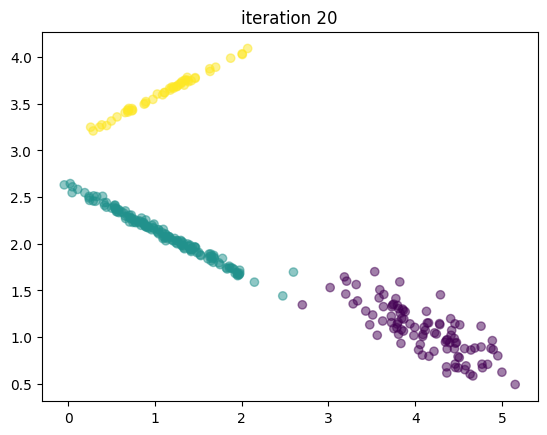

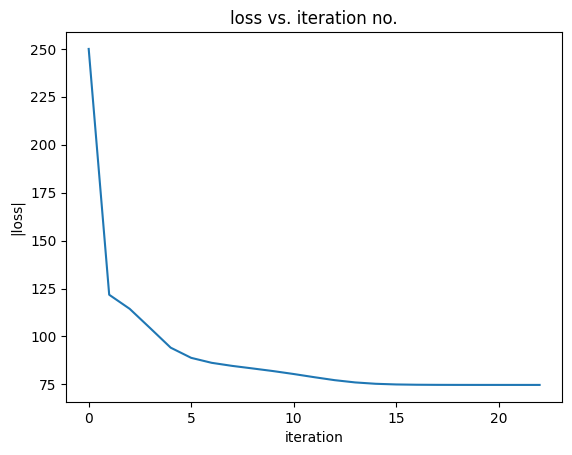

In [16]:
K = 3
centroids, membership, loss = fcm(data, K, centroids,max_iters = max_iters, fuzziness = fuzziness)
plot_loss(loss)

-1.6023605553527887e-08


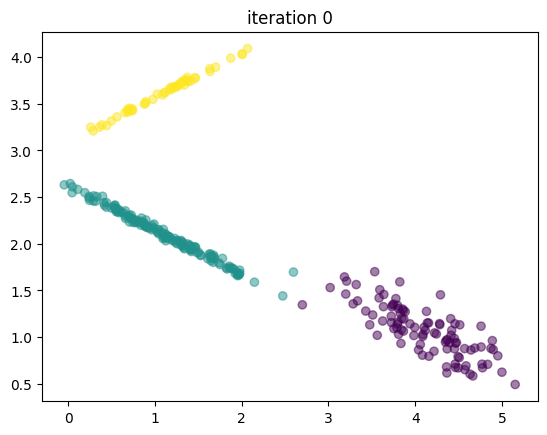

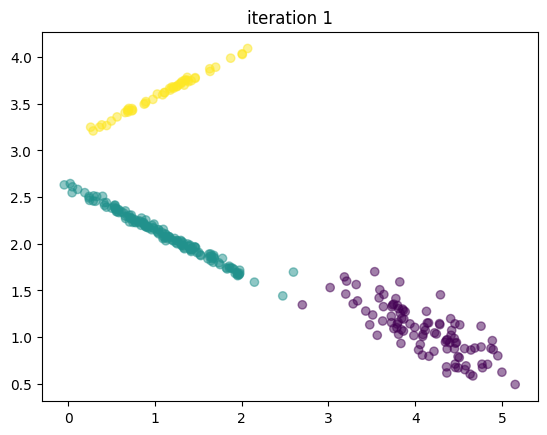

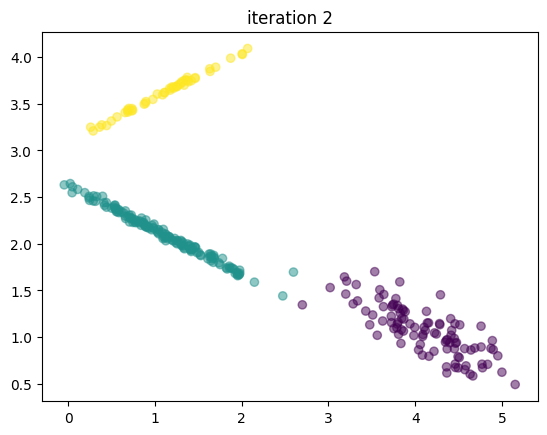

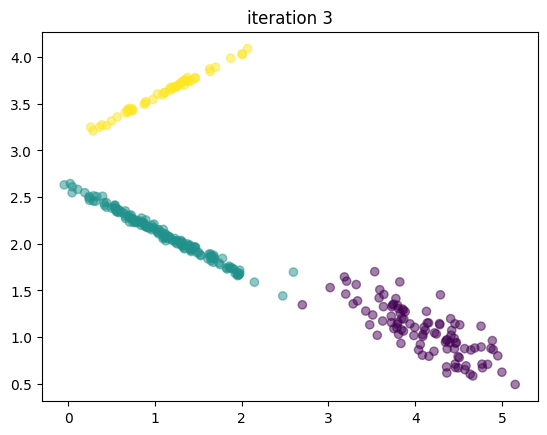

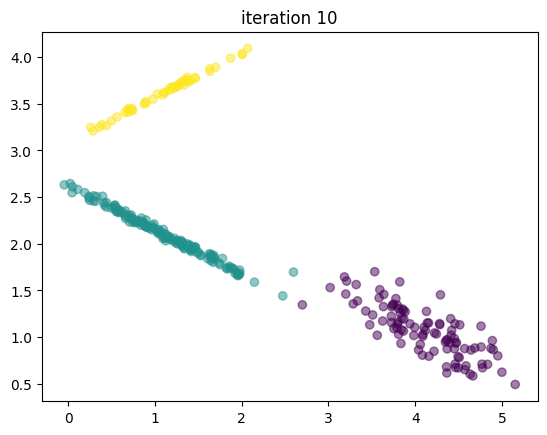

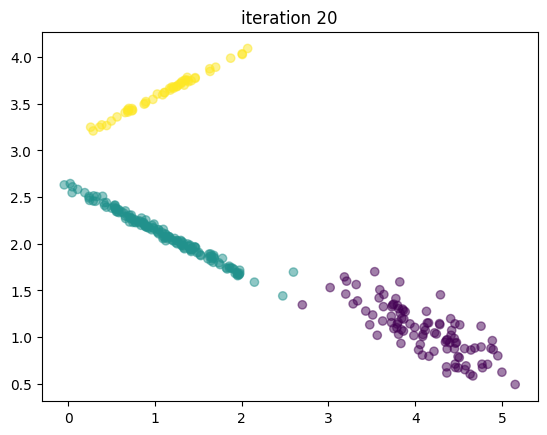

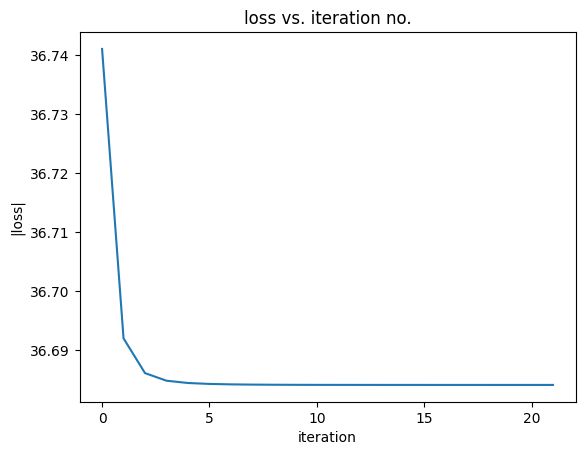

In [17]:
fuzziness = 3
centroids, membership, loss = fcm(data, K, centroids,max_iters = max_iters, fuzziness = fuzziness)
plot_loss(loss)

-2.1415574913419277e-07


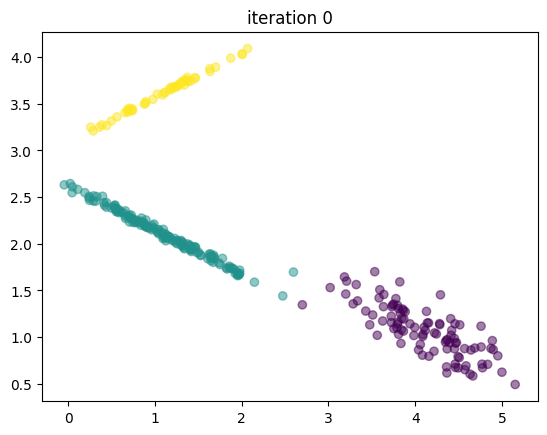

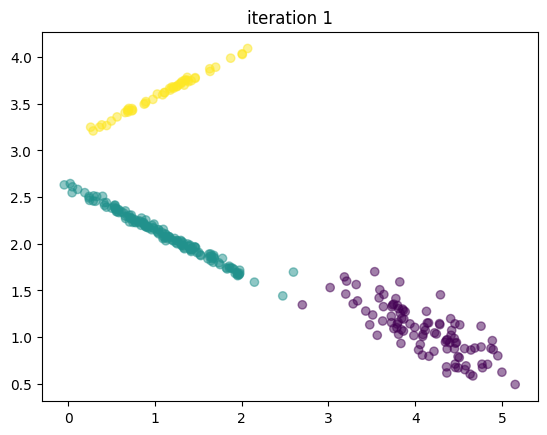

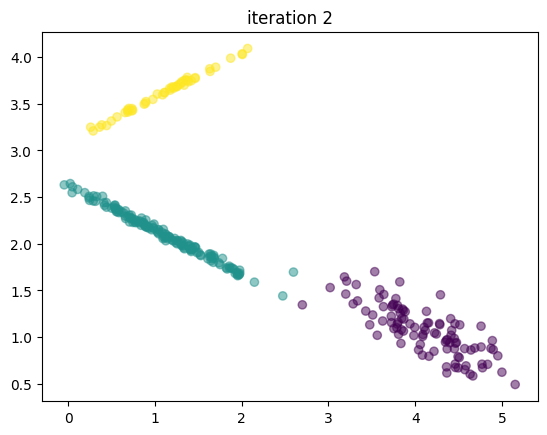

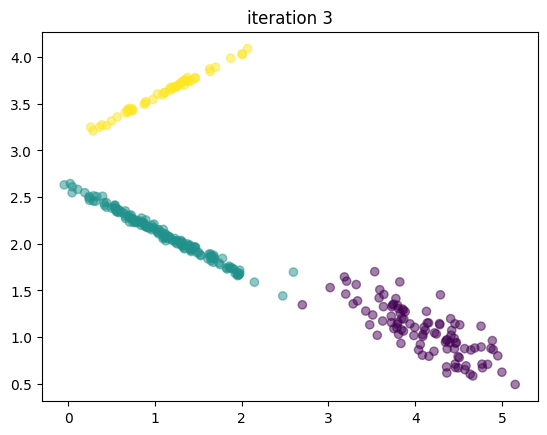

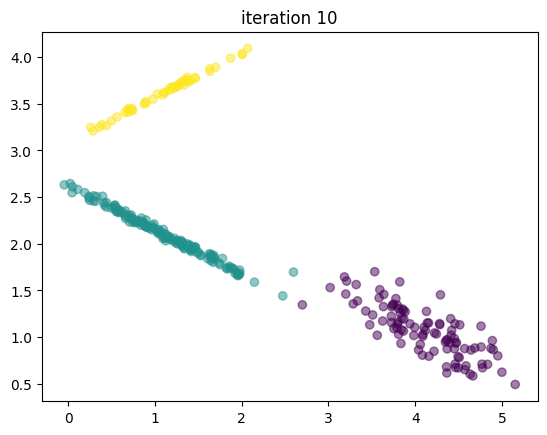

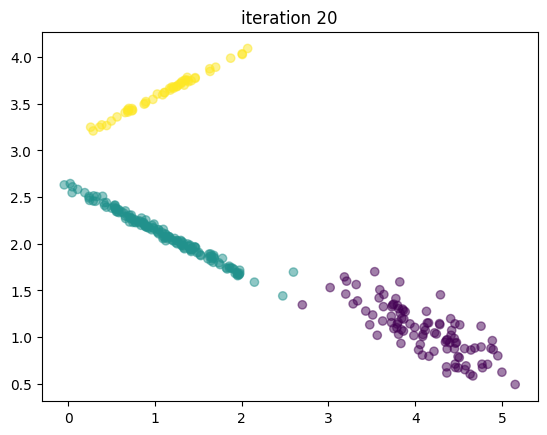

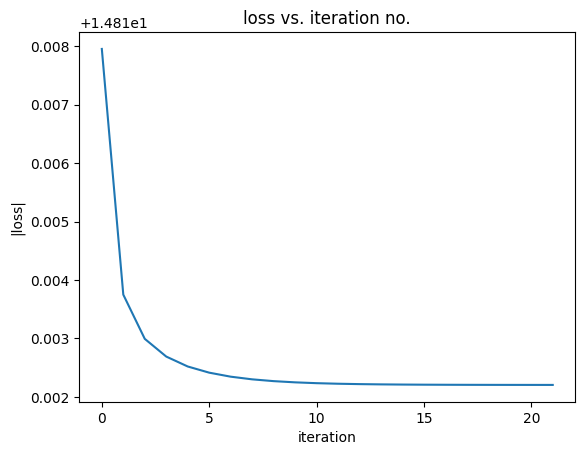

In [18]:
fuzziness = 4
centroids, membership, loss = fcm(data, K, centroids,max_iters = max_iters, fuzziness = fuzziness)
plot_loss(loss)

## Generate Data


In [19]:
## Generate Data

In [29]:
K = 4
N = 800
max_iters = 50
fuzziness = 6

clusters, data, phi, sigma = generate_clusters(K,d,N=400,distance=3)

centroids = np.random.rand(K, data.shape[1])





[0.26530024 0.35481089 0.15491716 0.22497172]
(array([1.37775554, 0.78971974]), array([[0.15344405, 0.17179551],
       [0.17179551, 0.23566973]]))


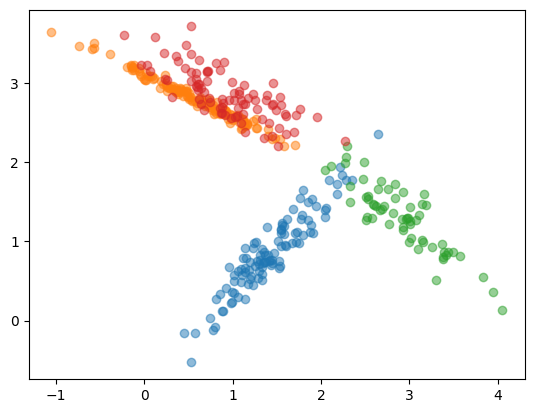

In [30]:
plot_clusters(clusters)

-6.202632079066461e-07


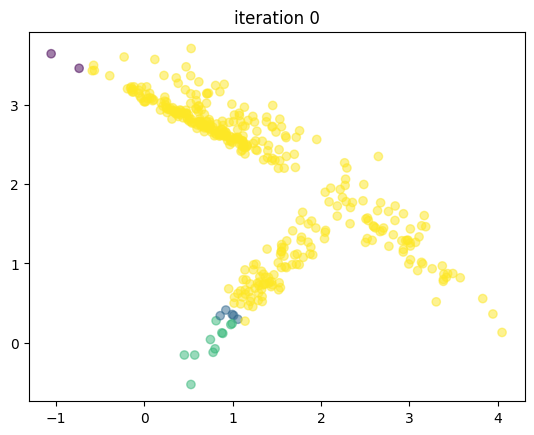

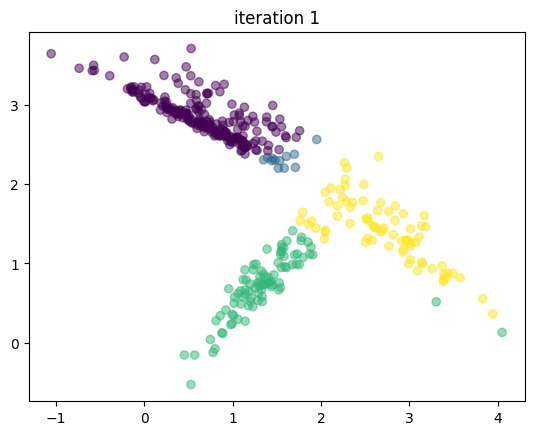

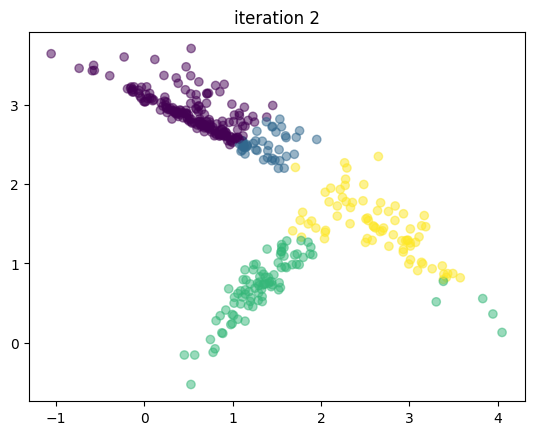

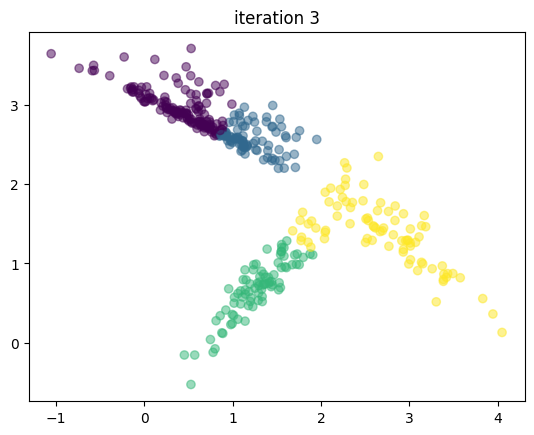

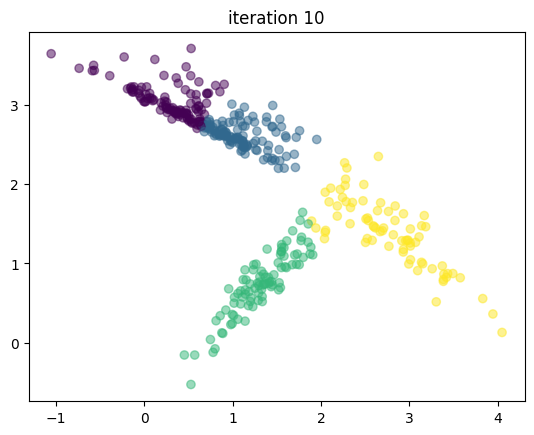

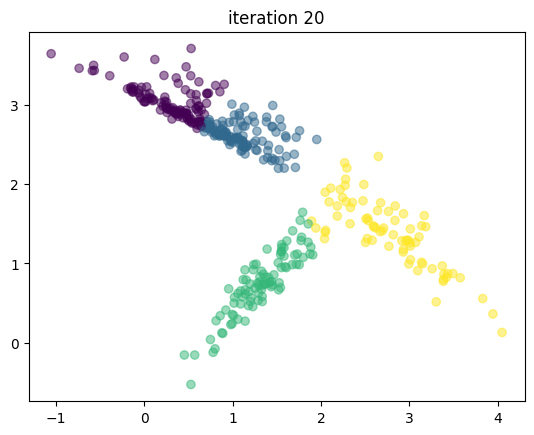

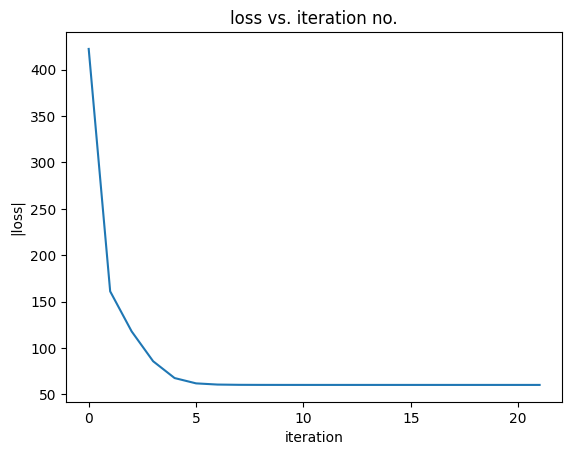

In [31]:
fuzziness = 2
centroids, membership, loss = fcm(data, K, get_rand_centroids(K,d),max_iters = max_iters, fuzziness = fuzziness)
plot_loss(loss)

-1.398576755917702e-05


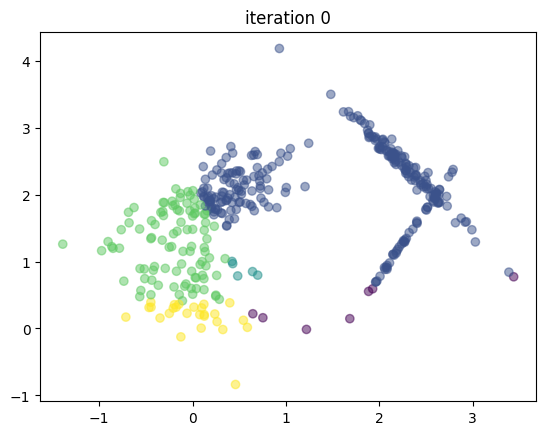

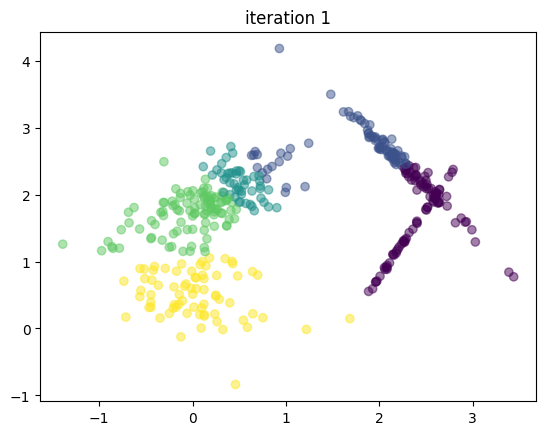

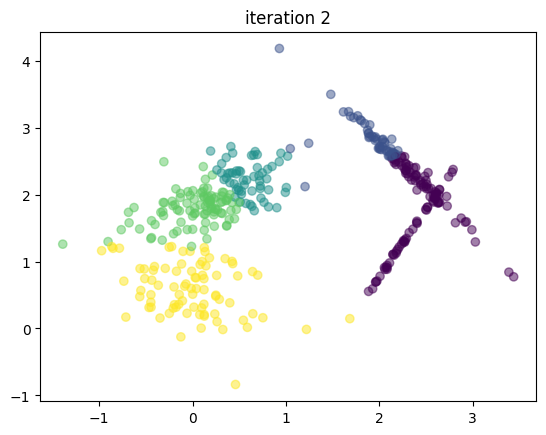

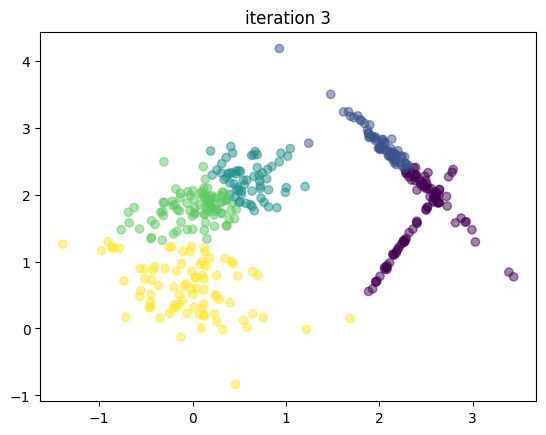

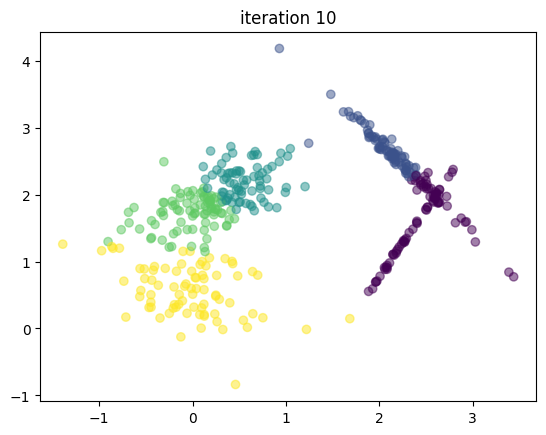

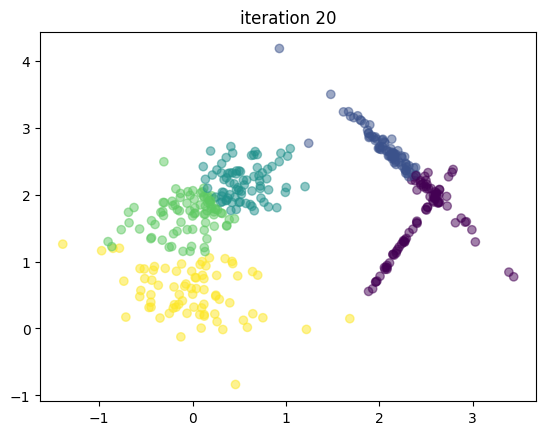

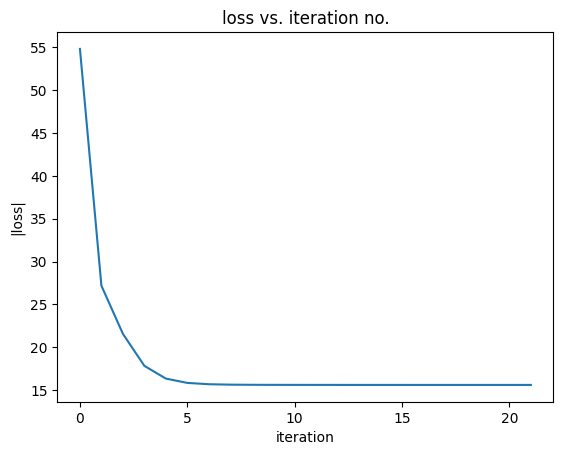

In [23]:
fuzziness = 3
centroids, membership, loss = fcm(data, K, get_rand_centroids(K,d),max_iters = max_iters, fuzziness = fuzziness)
plot_loss(loss)

-1.6337370158377856e-05


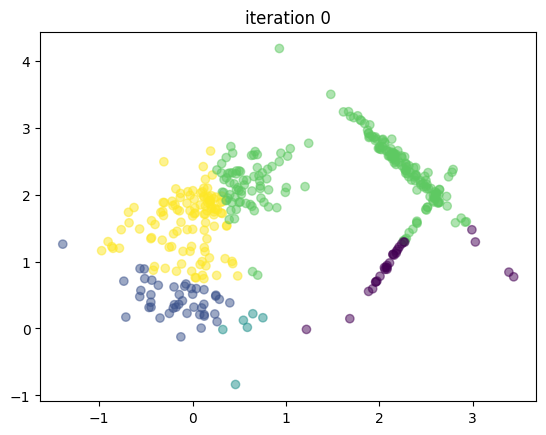

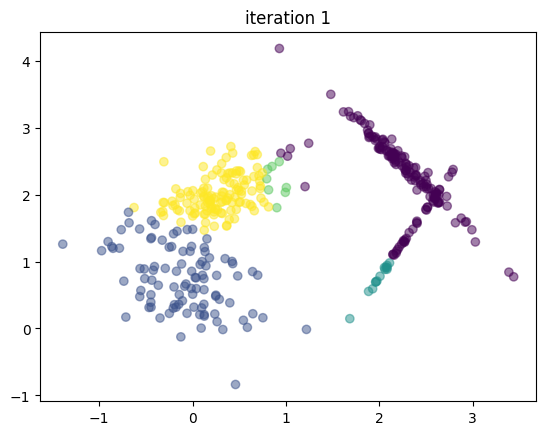

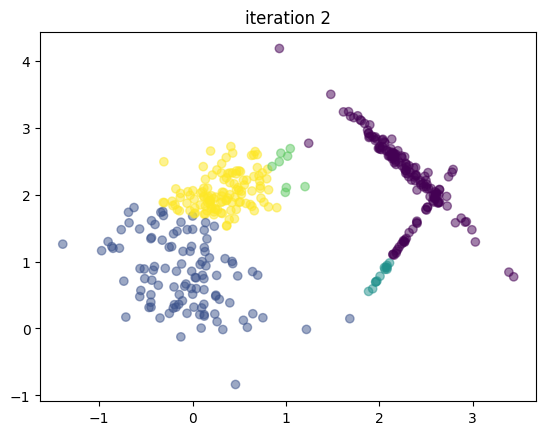

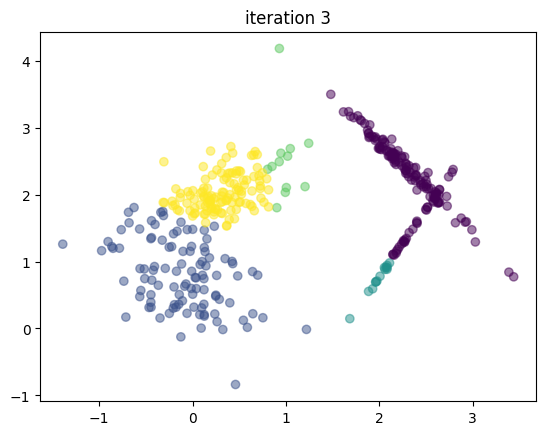

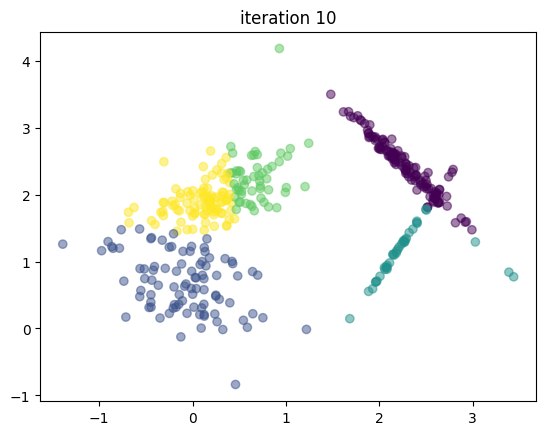

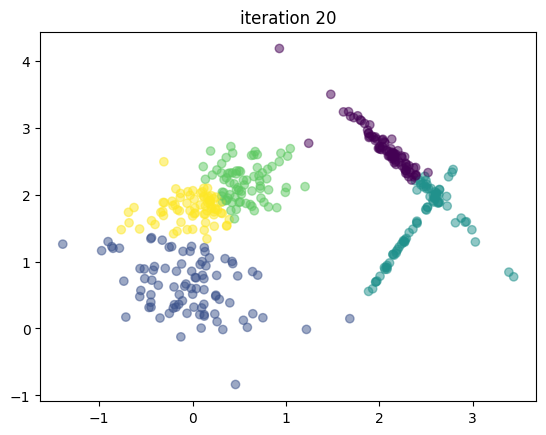

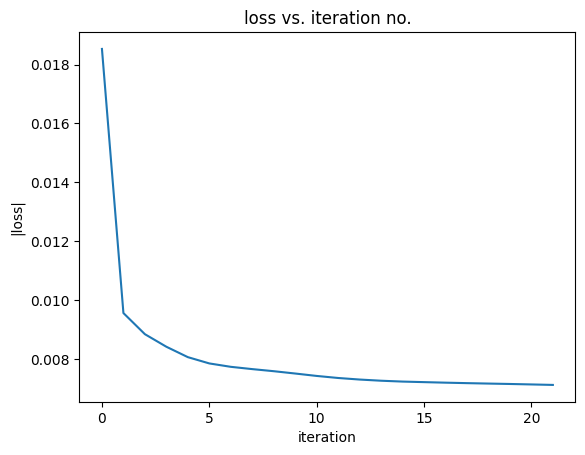

In [24]:
fuzziness = 8
centroids, membership, loss = fcm(data, K, get_rand_centroids(K,d),max_iters = max_iters, fuzziness = fuzziness)
plot_loss(loss)